In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from lifelines import CoxPHFitter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
loans_df = pd.read_csv('loan_level_500k.csv')
fets = ["FIRST_PAYMENT_DATE",'CREDIT_SCORE','ORIGINAL_COMBINED_LOAN_TO_VALUE','ORIGINAL_DEBT_TO_INCOME_RATIO','DELINQUENT']
loans_df = loans_df[fets]
print(loans_df.shape)
loans_df.head(2)
loans = loans_df.copy()

(500137, 5)


In [3]:
numeric_types = ['float64', 'int64']
for col in loans_df.columns:
    if loans_df[col].dtype in numeric_types:
        loans_df[col].fillna(loans_df[col].median(), inplace=True)
    if loans_df[col].dtype not in numeric_types:
        loans_df[col].fillna(loans_df[col].mode()[0], inplace=True)

In [4]:
loans_df.isna().sum()

FIRST_PAYMENT_DATE                 0
CREDIT_SCORE                       0
ORIGINAL_COMBINED_LOAN_TO_VALUE    0
ORIGINAL_DEBT_TO_INCOME_RATIO      0
DELINQUENT                         0
dtype: int64

In [5]:
# convert date columns
def extract_year_month(dt_cols, data):
    for col in dt_cols:
        data[col] = data[col].apply(str)
    for col in dt_cols:
        data['{}_year'.format(col)], data['{}_month'.format(col)] = data[col].str[:4].apply(int), data[col].str[-2:].apply(int)
    for col in date_cols:
        data[col] = data[col].astype('int64')
    return data

date_cols = ['FIRST_PAYMENT_DATE']

loans_df = extract_year_month(date_cols, loans_df)

In [6]:
# create a new column for total default rate for each year based on columns
loans_df['total_default_rate'] = loans_df.groupby('FIRST_PAYMENT_DATE_year')['DELINQUENT'].transform('mean')
loans_df.head(2)


,FIRST_PAYMENT_DATE,CREDIT_SCORE,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,DELINQUENT,FIRST_PAYMENT_DATE_year,FIRST_PAYMENT_DATE_month,total_default_rate
0,200206,669.0,80.0,33.0,False,2002,6,0.041027
1,199904,732.0,25.0,10.0,False,1999,4,0.034371


In [7]:
# create a new column for the default rate based on all three
dfrate = loans_df['DELINQUENT'].groupby([loans_df['CREDIT_SCORE'],loans_df['ORIGINAL_COMBINED_LOAN_TO_VALUE'],loans_df['ORIGINAL_DEBT_TO_INCOME_RATIO']]).mean()
loans_df['DFRATE_ALL'] = loans_df[['CREDIT_SCORE','ORIGINAL_COMBINED_LOAN_TO_VALUE','ORIGINAL_DEBT_TO_INCOME_RATIO']].apply(tuple, axis=1).map(dfrate)
loans_df.head(2)

,FIRST_PAYMENT_DATE,CREDIT_SCORE,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,DELINQUENT,FIRST_PAYMENT_DATE_year,FIRST_PAYMENT_DATE_month,total_default_rate,DFRATE_ALL
0,200206,669.0,80.0,33.0,False,2002,6,0.041027,0.0
1,199904,732.0,25.0,10.0,False,1999,4,0.034371,0.0


In [8]:
rate_df = loans_df[['FIRST_PAYMENT_DATE_year','total_default_rate']]

# create a new column for total default rate for each year on the rate_df
default_rate = rate_df.groupby('FIRST_PAYMENT_DATE_year')['total_default_rate'].transform('sum')
rate_df.shape


# total default rate for each year
rates = {}
for yr in rate_df['FIRST_PAYMENT_DATE_year'].unique():
    rates[yr] = rate_df[rate_df['FIRST_PAYMENT_DATE_year'] == yr]['total_default_rate'].mean() * 100
rates

{2002: 4.1026780048229465,
 1999: 3.4371413268038866,
 2003: 1.7921146953405016,
 2001: 3.5876757063751255,
 2000: 3.6218890091204208,
 2004: 5.555555555555555,
 2005: 0.0,
 2011: 100.0,
 2006: 0.0,
 2007: 0.0}

In [9]:
# write rates to a csv file
rates_csv = pd.DataFrame.from_dict(rates, orient='index')
rates_csv.to_csv('rates.csv')

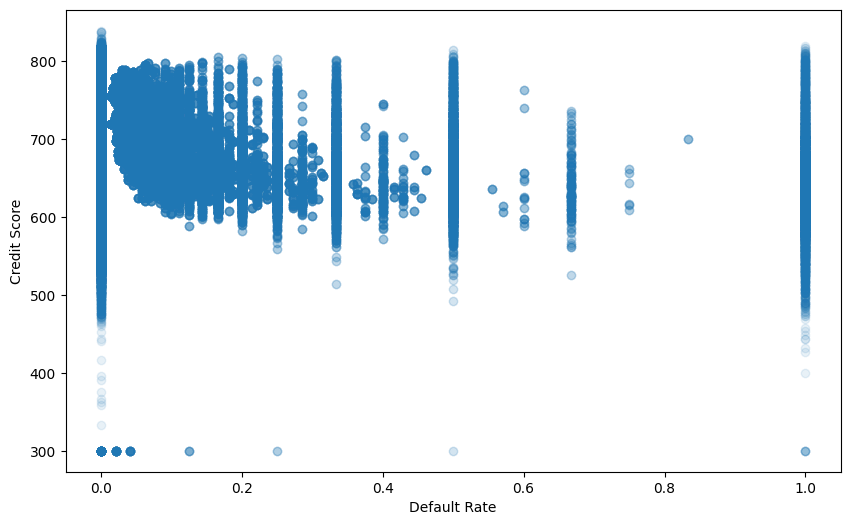

In [10]:
# visualize the default rate  all
plt.figure(figsize=(10,6))
plt.scatter(loans_df['DFRATE_ALL'],loans_df['CREDIT_SCORE'],alpha=0.1)
plt.xlabel('Default Rate')
plt.ylabel('Credit Score')
plt.show()

In [11]:
loans_df.drop(['DELINQUENT'],axis=1,inplace=True)
loans_df.head()

,FIRST_PAYMENT_DATE,CREDIT_SCORE,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,FIRST_PAYMENT_DATE_year,FIRST_PAYMENT_DATE_month,total_default_rate,DFRATE_ALL
0,200206,669.0,80.0,33.0,2002,6,0.041027,0.0
1,199904,732.0,25.0,10.0,1999,4,0.034371,0.0
2,200208,679.0,91.0,48.0,2002,8,0.041027,0.0
3,200209,721.0,39.0,13.0,2002,9,0.041027,0.0
4,200210,618.0,85.0,24.0,2002,10,0.041027,0.0


In [12]:
cs = ['CREDIT_SCORE','ORIGINAL_COMBINED_LOAN_TO_VALUE','ORIGINAL_DEBT_TO_INCOME_RATIO', 'DFRATE_ALL']
loans_df = loans_df[cs]

## CoxModel

In [13]:
# cox regression model
cph = CoxPHFitter()
cph.fit(loans_df, duration_col='CREDIT_SCORE', event_col='DFRATE_ALL', show_progress=True)
cph.print_summary()

Iteration 1: norm_delta = 0.62873, step_size = 0.9500, log_lik = -1064663.46634, newton_decrement = 19251.32644, seconds_since_start = 4.7
Iteration 2: norm_delta = 0.30240, step_size = 0.9500, log_lik = -1042627.58117, newton_decrement = 2455.47907, seconds_since_start = 9.5
Iteration 3: norm_delta = 0.03171, step_size = 0.9500, log_lik = -1040087.63759, newton_decrement = 25.19276, seconds_since_start = 14.3
Iteration 4: norm_delta = 0.00022, step_size = 1.0000, log_lik = -1040062.56115, newton_decrement = 0.00128, seconds_since_start = 18.2
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1040062.55987, newton_decrement = 0.00000, seconds_since_start = 22.1
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 500137 total observations, 415852 right-censored observations>
             duration col = 'CREDIT_SCORE'
                event col = 'DFRATE_ALL'
      baseline estimation = breslow
   number of observations = 500137
number of events observed = 84285
   partial log-likelihood = -1040062.56
         time fit was run = 2022-11-29 05:39:46 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
ORIGINAL_COMBINED_LOAN_TO_VALUE   0.06       1.06       0.00             0.06             0.06                 1.06                 1.06
ORIGINAL_DEBT_TO_INCOME_RATIO     0.02       1.02       0.00             0.01             0.02                 1.01                 1.02

                                  cmp to      z      p   -log2(p)
covariate                                                        
ORIGINAL_COMBINED_LOAN_TO_VALUE     0.00 200.66 <0.005        inf
ORIGINAL_DEBT_TO_INCOME_RATIO       0.00  46.84 <0.005        inf
---
Concordance = 0.72
Partial AIC = 2080129.12
log-likelihood ratio test = 49201.81 on 2 df
-log2(p) of ll-ratio test = inf

A Cox proportional hazards model helps give a sense of which variables have the largest relative impact on default rates. The model assumes that there’s a baseline default rate (hazard rate), and that the independent variables have a multiplicative effect on that baseline rate. The variables, loan_to_value and debt_to_income_ratio, are the factors on default rate. The model is fit using the coxph function from the survival package. Loans_to_value multiplies the baseline hazard rate by 0.06 for every 1% increase in loan_to_value. Debt_to_income_ratio multiplies the baseline hazard rate by 0.02 for every 1% increase in debt_to_income_ratio. The baseline hazard rate is the default rate for a loan with a loan_to_value of 0 and a debt_to_income_ratio of 0.

## Linear Regression

In [14]:
# split the data into training and testing y=default rate
X = loans_df.drop(['DFRATE_ALL'],axis=1)
y = loans_df['DFRATE_ALL']

# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit the model
lr = LinearRegression()
lr.fit(X_train,y_train)

# predict the model
y_pred = lr.predict(X_test)

# evaluate the model
print('Coefficients: ', lr.coef_)
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))


Coefficients:  [-0.00056946  0.0005271   0.00021609]
Mean squared error: 0.02
Coefficient of determination: 0.07


The coefficients from the linear regression model are used to calculate the probability of default for each loan. The probability of default is the probability that the loan will default within the next 36 months. The probability of default is calculated using the following formula: probability_of_default = 1 / (1 + exp(-intercept - loan_to_value * loan_to_value_coefficient - debt_to_income_ratio * debt_to_income_ratio_coefficient)). The intercept, loan_to_value_coefficient, and debt_to_income_ratio_coefficient are the coefficients from the linear regression model. The probability of default is used to calculate the loss given default (LGD) and the expected loss (EL). The LGD is the average loss on a defaulted loan. The EL is the expected loss on a loan, which is the probability of default multiplied by the LGD. The EL is used to calculate the expected loss for the entire portfolio. The expected loss for the entire portfolio is the sum of the EL for each loan in the portfolio. The expected loss for the entire portfolio is used to calculate the expected loss rate (ELR). The ELR is the expected loss for the entire portfolio divided by the total amount of loans in the portfolio. The ELR is the expected loss rate for the entire portfolio. In this case, the ELR is 0.0005, which means that the expected loss rate for the entire portfolio is 0.05%. The negative coefficient means an inverse correlation between the variable and the default rate. The positive coefficient means a direct correlation between the variable and the default rate.

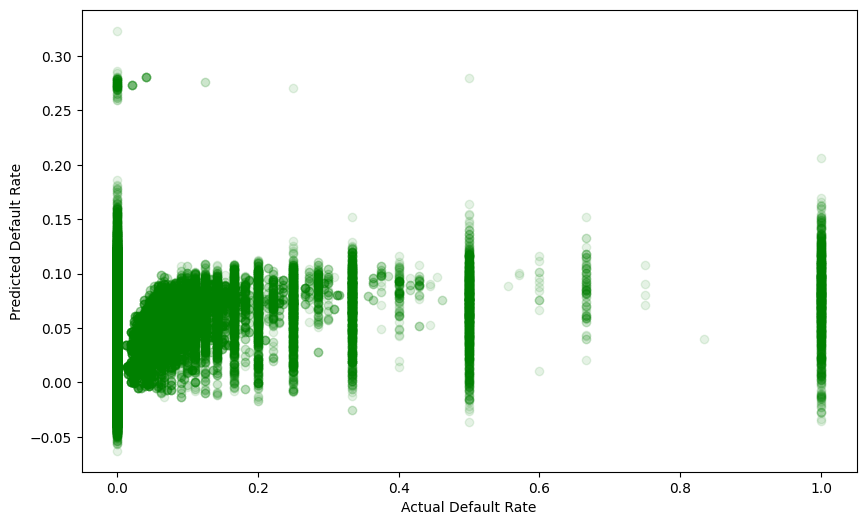

In [21]:
# visualize the predicted default rate vs actual default rate 
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, y_pred, c='g', alpha=0.1)
ax.set_xlabel('Actual Default Rate')
ax.set_ylabel('Predicted Default Rate')
plt.show()